In [63]:
import keras
keras.__version__

from keras.models import load_model
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=False)
model.summary()  # As a reminder.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [64]:
print(size)

64


### [20 Points] Manipulate the code from the CNN visualization notebook to implement the DeepDream process. This includes:
* Using L1 gradient normalization for gradient updates
* Adding random shifts/resizing in the process (as described in DeepDream)
* If using code from another source, you must heavily document the code so that I can grade your understanding of the code used. 

In [65]:
from keras.applications import VGG16
from keras import backend as K

# Selecting a layer and channel to visualize
layer_name = 'block3_conv1'
filter_index = 0

# Isolate the output and loss for the given chanel
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, model.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L1 norm
# (the mean of the values in the tensor). We add a small epsilon term to the L2 norm
# to avoid division by zero.
grads /= K.mean(grads) + 1e-5

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([model.input], [loss, grads])

# To quickly test the interface:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [66]:
size

64

When we perform gradient descent and iteratively update the blank image, the result is not guaranteed to be a valid, displayable image. We can fix that using a simple utility function below:

In [67]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

(1, 150, 150, 3)


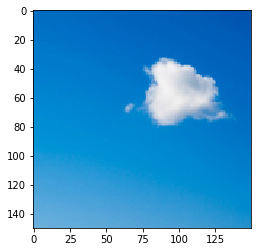

In [105]:
import copy

img_url = 'https://i.ebayimg.com/images/g/AFYAAOSwVh9cstw3/s-l1600.jpg'
img_url = 'https://www.cfse.cam.ac.uk/images/blue_sky_cloud/image_preview'
# img_url = 'https://raw.githubusercontent.com/8000net/LectureNotes/master/images/dog.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
# use this to install PIL: conda install --channel conda-forge pillow=5
from PIL import Image

def load_image_as_array(url, size=(150, 150)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    return np.array(img).astype(float)

img_tensor = load_image_as_array(img_url)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)
img_drawing = copy.deepcopy(img_tensor)
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [106]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import scipy

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [107]:

def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= K.mean(grads) + 1e-5
#     grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)


    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
#     input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    input_img_data = img_drawing
#     print(input_img_data)
    input_img_data = resize_img(input_img_data, (size,size))
    
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img), img

(150, 150, 3)


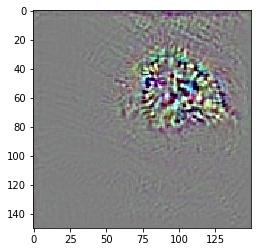

In [112]:
filter_output1, filter_output2 = generate_pattern('block5_conv3',2)
plt.imshow(filter_output1)
print(filter_output1.shape)
plt.show()

(150, 150, 3)


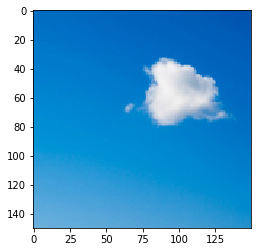

In [113]:
print(img_drawing[0].shape)
plt.imshow(img_drawing[0])

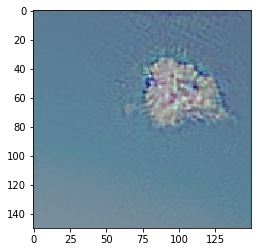

In [114]:
img_merge = img_drawing[0]+filter_output2
plt.imshow(deprocess_image(img_merge))

64


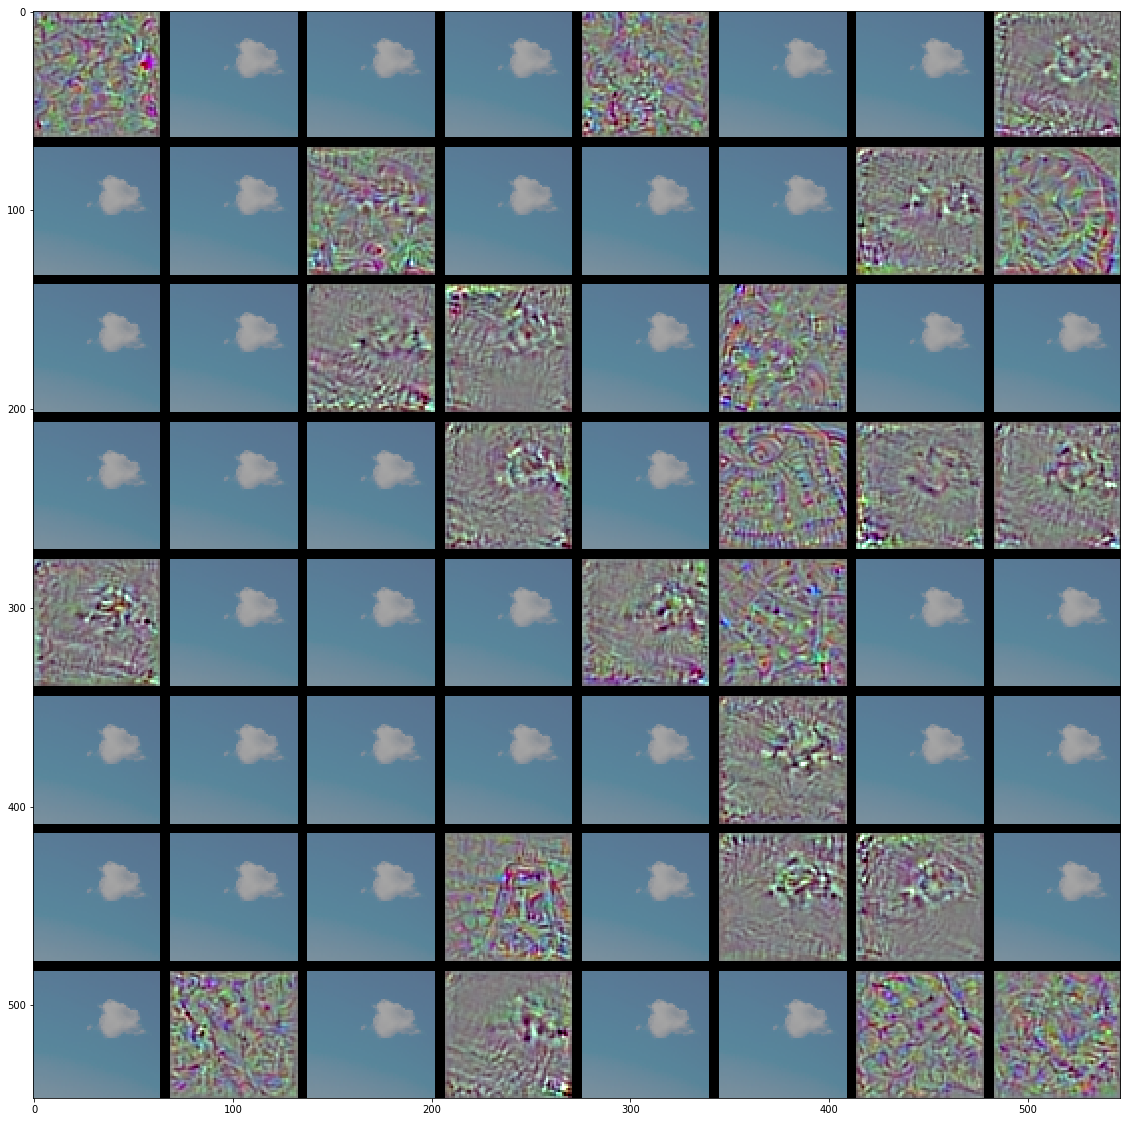

CPU times: user 12min 2s, sys: 3min 32s, total: 15min 34s
Wall time: 6min


In [116]:
%%time
for layer_name in ['block5_conv3']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))
    print(size)
    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img, nothing = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.astype(int))
    plt.show()

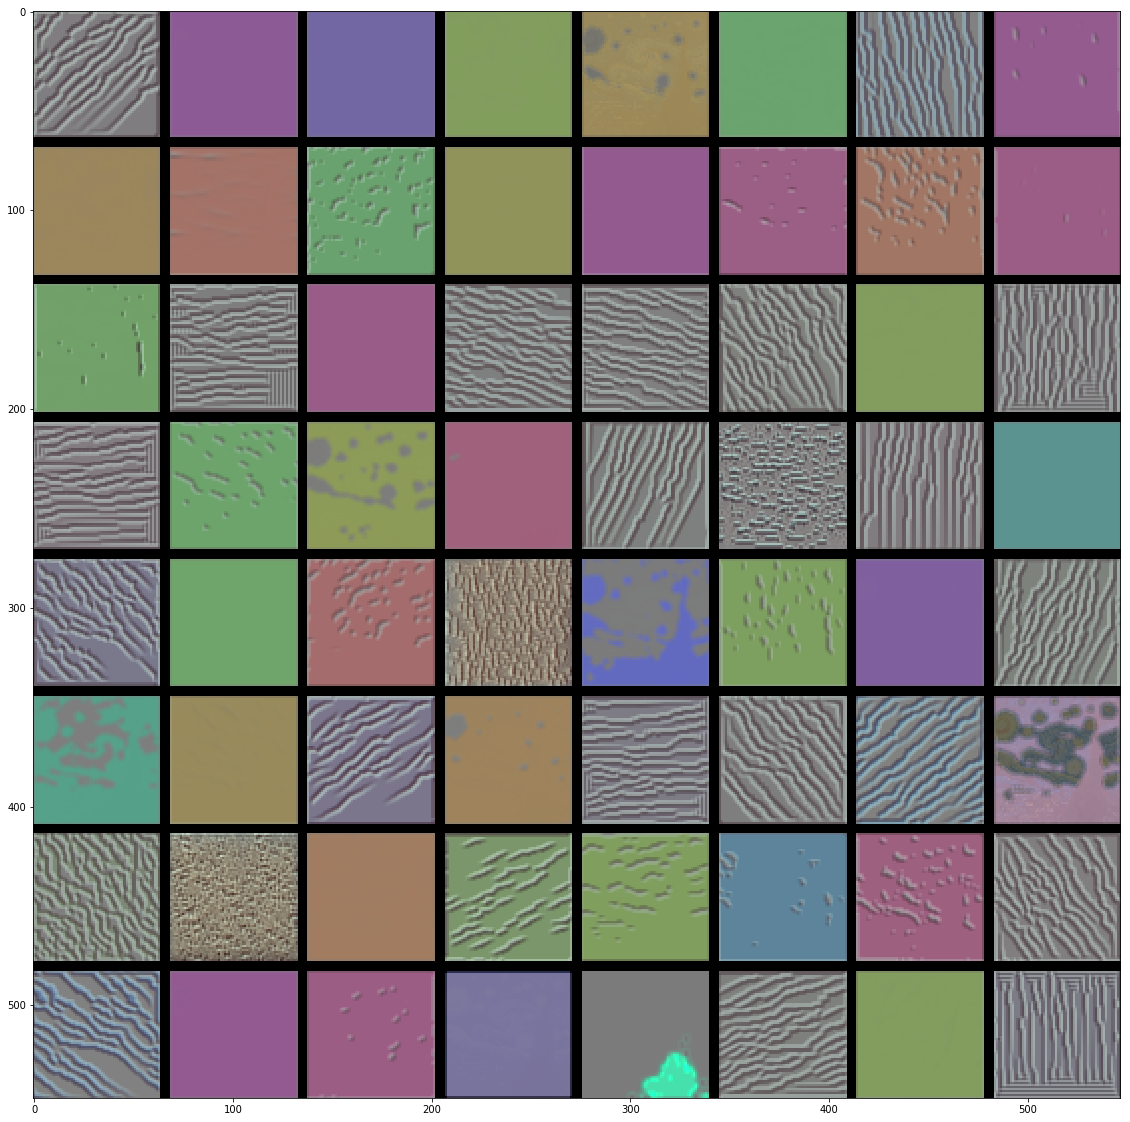

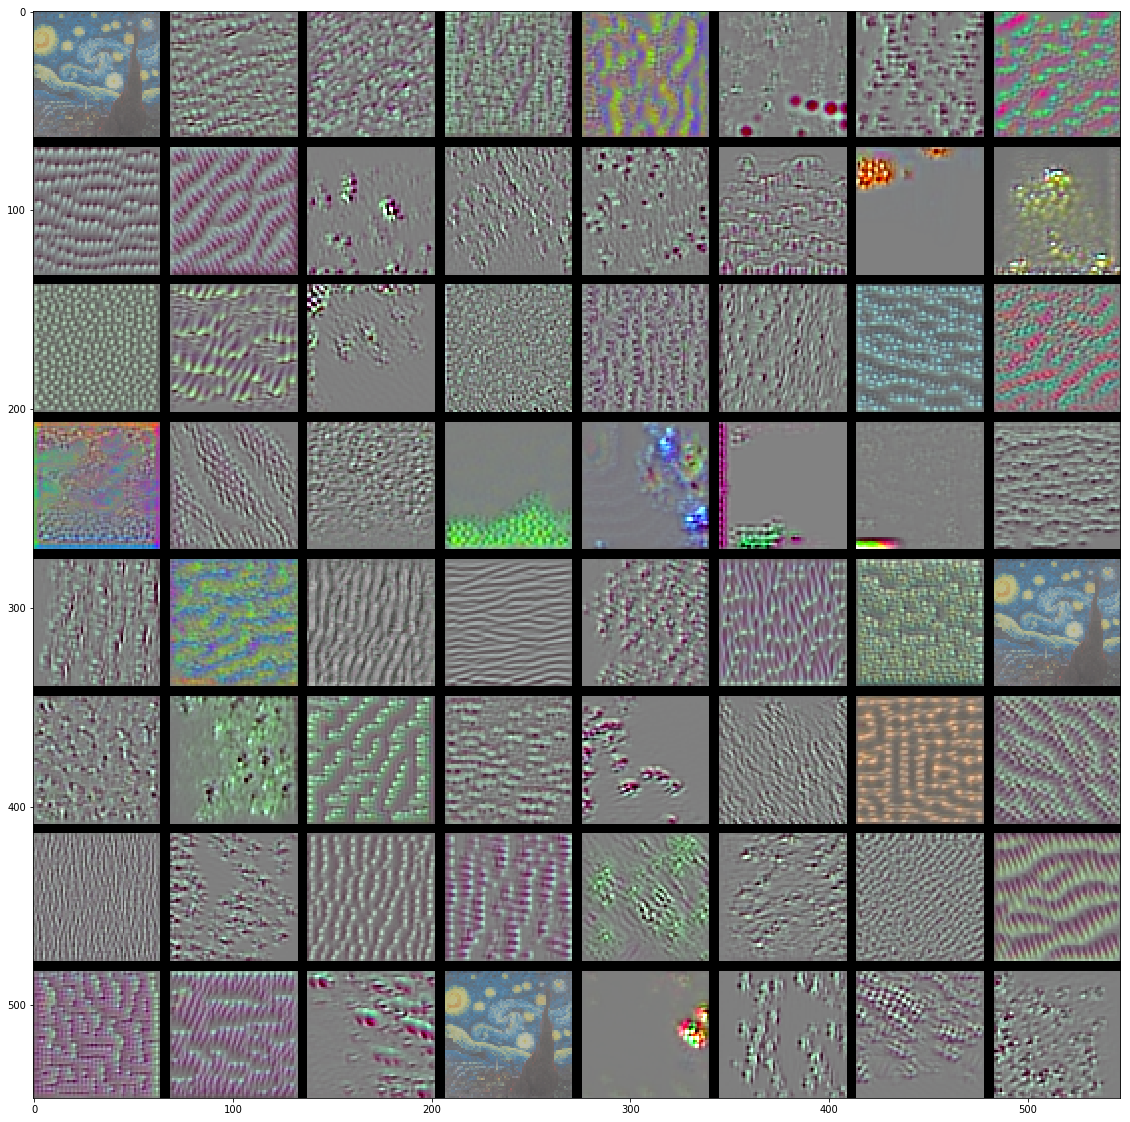

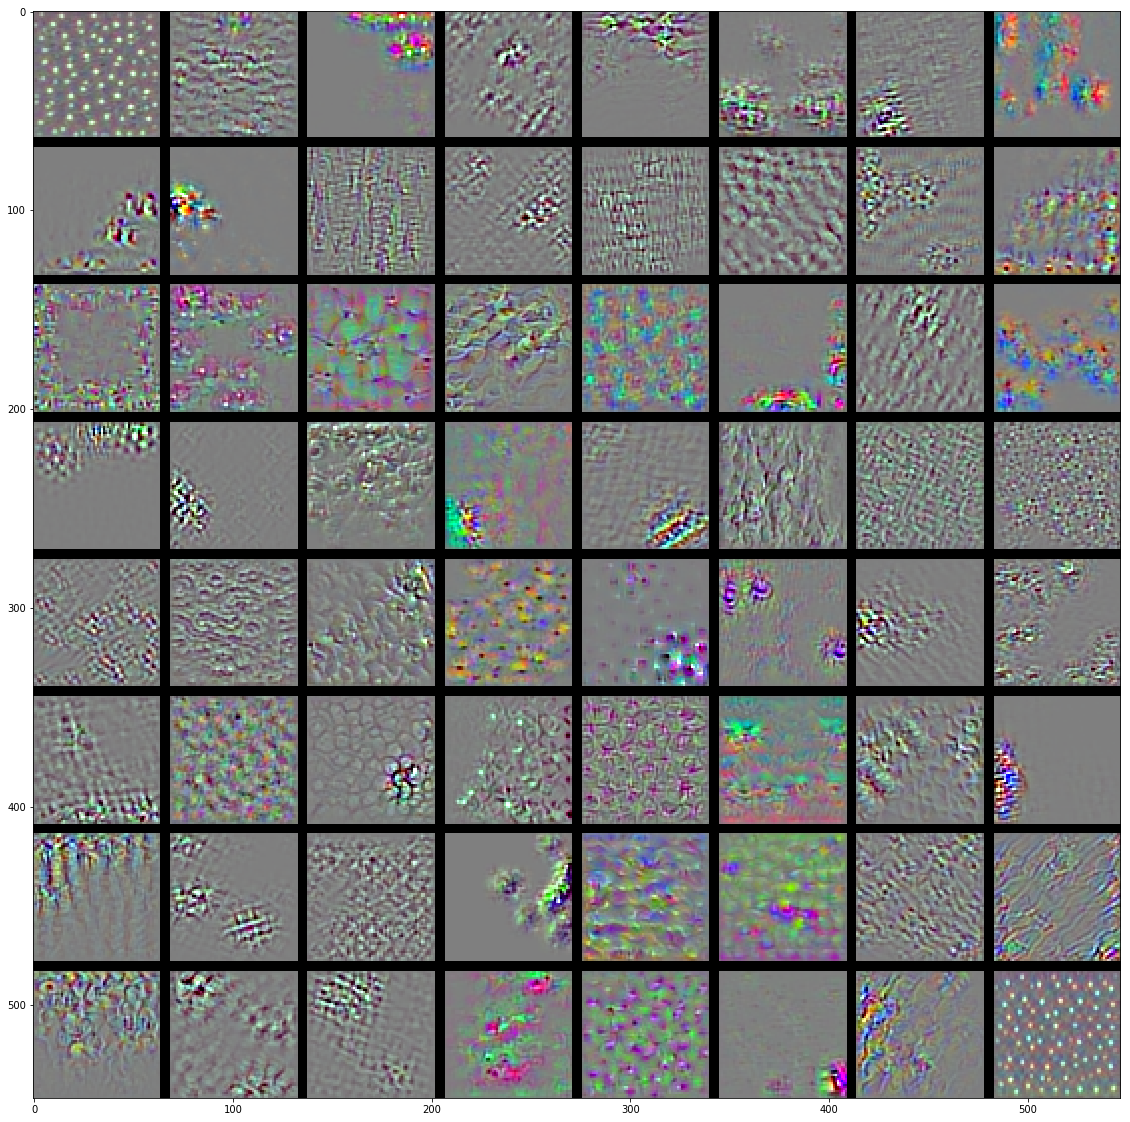

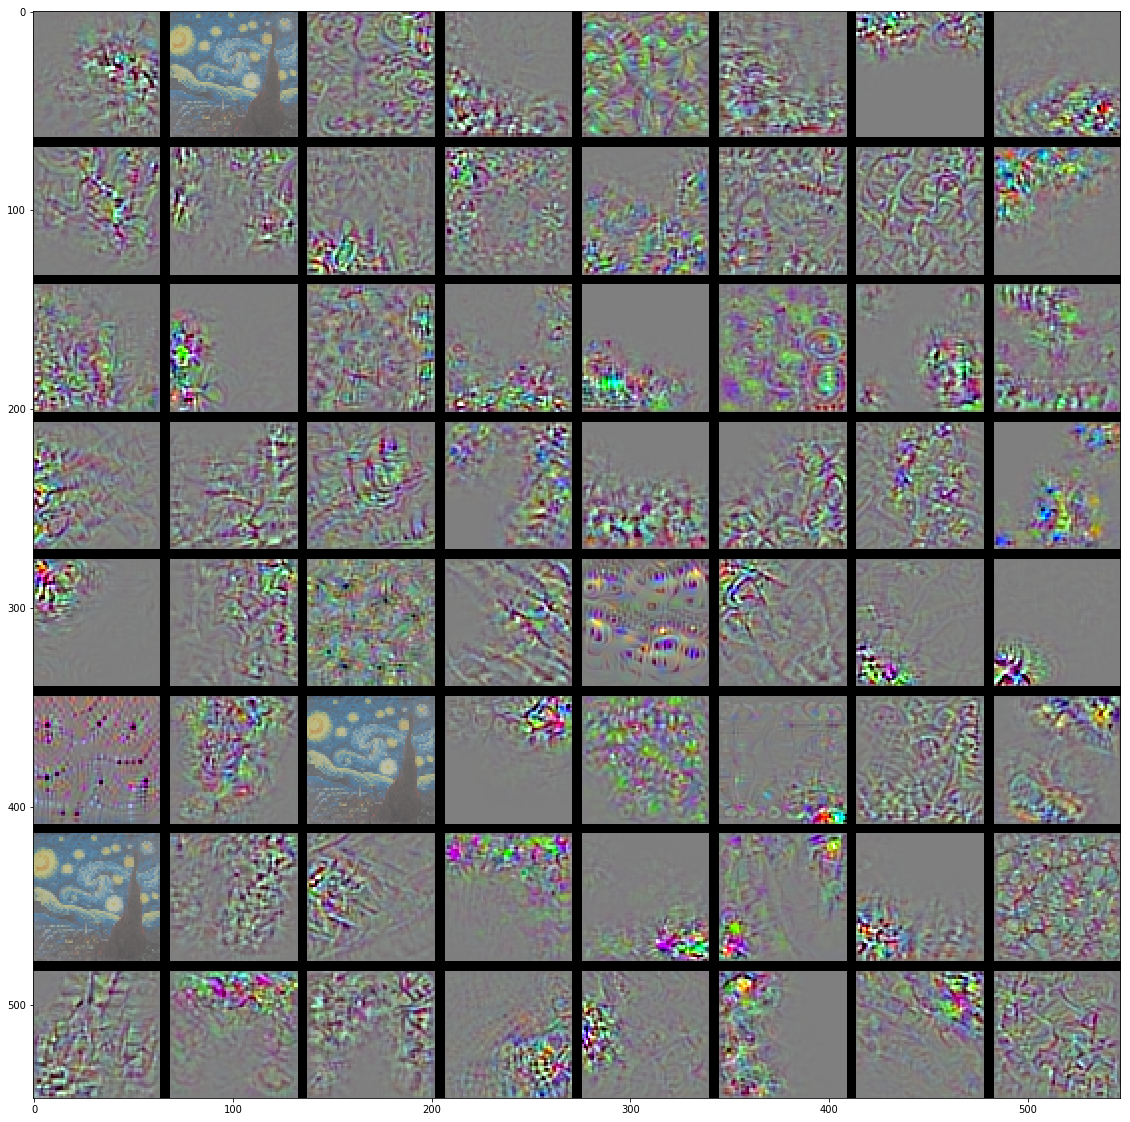

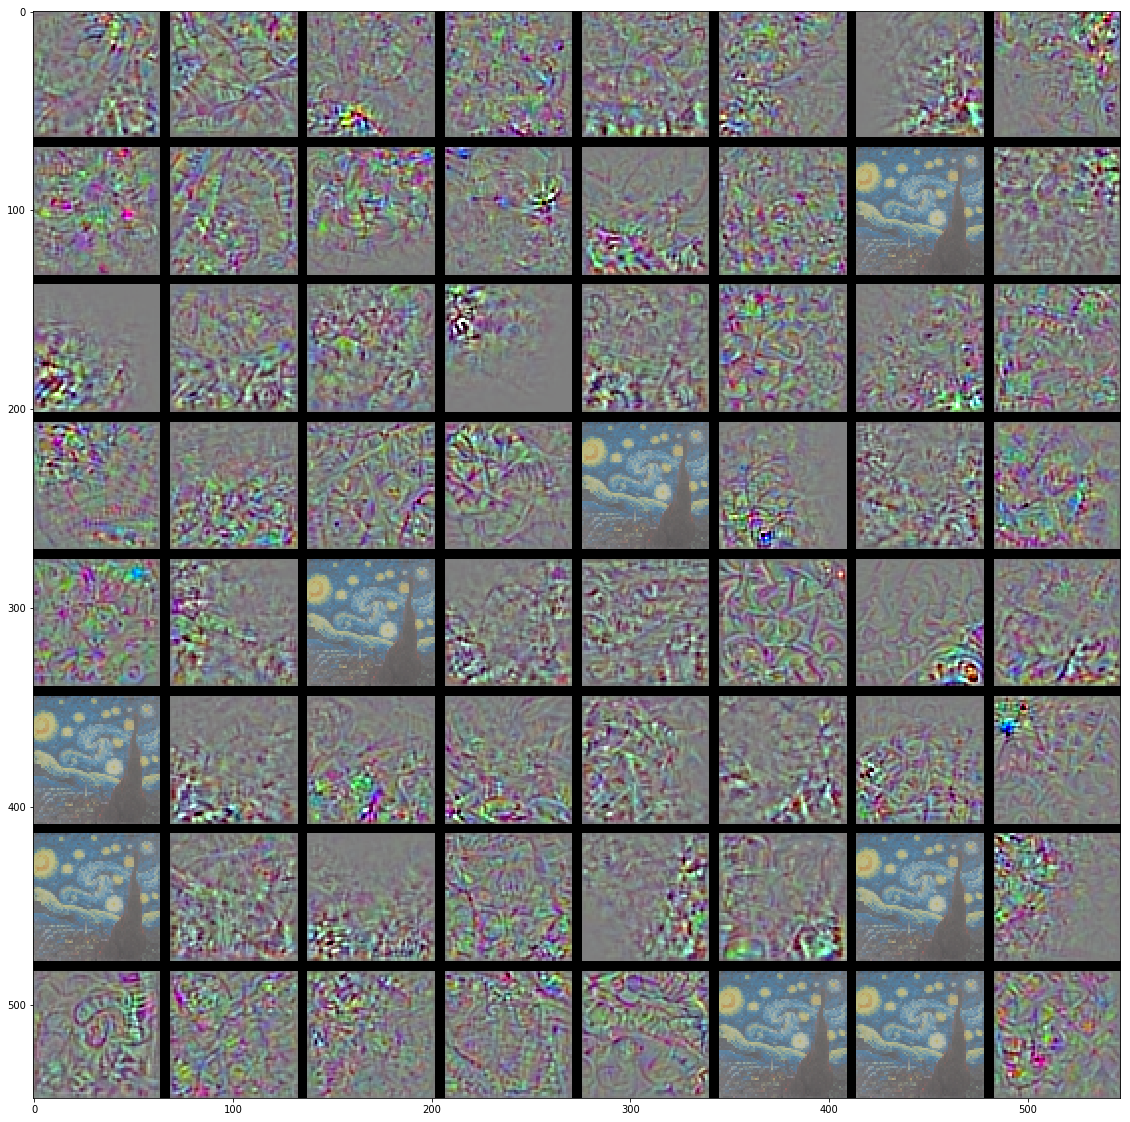

CPU times: user 22min 55s, sys: 5min 43s, total: 28min 38s
Wall time: 11min 34s


In [40]:
%%time
for layer_name in ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.astype(int))
    plt.show()

In [13]:
randompic = np.random.random((1, size, size, 3)) * 20 + 128.
print(size)
print(randompic.shape)

64
(1, 64, 64, 3)


In [14]:
print(img_drawing.shape)

(1, 150, 150, 3)


In [46]:
after_process_img = keras.applications.vgg16.preprocess_input(img_drawing)
after_process_img.shape

(1, 150, 150, 3)

In [59]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

if K.image_data_format() == 'channels_first':
    original_shape = after_process_img.shape[2:]
else:
    original_shape = after_process_img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(after_process_img)
shrunk_original_img = resize_img(after_process_img, successive_shapes[0])

# def gradient_ascent(x, iterations, step, max_loss=None):
#     for i in range(iterations):
#         loss_value, grad_values = eval_loss_and_grads(x)
#         if max_loss is not None and loss_value > max_loss:
#             break
#         print('..Loss value at', i, ':', loss_value)
#         x += step * grad_values
#     return x


for shape in successive_shapes:
    print('Processing image shape', shape)
    after_process_img = resize_img(after_process_img, shape)
    
    ##
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= K.mean(grads) + 1e-5
#     grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)


    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
#     after_process_img = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(10):
        loss_value, grads_value = iterate([after_process_img])
        after_process_img += grads_value * step
    
#     after_process_img = gradient_ascent(after_process_img,
#                           iterations=iterations,
#                           step=step,
#                           max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    after_process_img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (19, 19)
Processing image shape (27, 27)
Processing image shape (38, 38)


In [60]:
deprocess_image(np.copy(after_process_img)).shape

(1, 38, 38, 3)

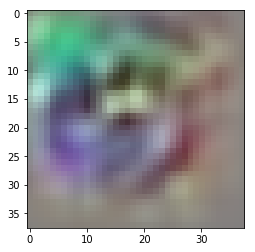

In [61]:
plt.imshow(deprocess_image(np.copy(after_process_img))[0])

## Offical document

In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications import inception_v3

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

imagePath = '/Users/ouyang/Desktop/CSE8324AdvancedMachineLearning/LectureNotesMaster-master/images/dog.jpg'
img = preprocess_image(imagePath)
print(img.shape)
plt.imshow(img[0])

In [ ]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss.assign_add(coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling)
    else:
        loss.assign_add(coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling)

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
# grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
grads /= K.mean(grads) + 1e-5

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)